# Lab6.3-Topic-modelling

This notebook shows how to build a topic model using Latent Dirichlet Allocation using the Sklearn package.

Credits: This notebook is an adaptation of the work of Shashank Kapadia:

https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/

The dataset can be found here: https://www.kaggle.com/benhamner/nips-papers


In [15]:
# Importing modules
import pandas as pd

# Read data into papers
papers = pd.read_csv('papers.csv')

# Print head
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


#### Data Cleaning

Since the goal of this analysis is to perform topic modeling, we will solely focus on the text data from each paper, and drop other metadata columns

In [17]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1)

# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


#### Remove punctuation/lower casing

Next, let’s perform a simple preprocessing on the content of paper_text column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text. Note that we care less about the linguistic notion of words and sentences since we treat the text as a basic bag-of-words.

In [19]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub(r'[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

0    767\n\nself-organization of associative databa...
1    683\n\na mean field theory of layer iv of visu...
2    394\n\nstoring covariance by the associative\n...
3    bayesian query construction for neural\nnetwor...
4    neural network ensembles cross\nvalidation and...
Name: paper_text_processed, dtype: object

#### Exploratory Analysis

To verify whether the preprocessing happened correctly, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

You can install WordCloud from the command line following the instructions at:

https://anaconda.org/conda-forge/wordcloud


In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

#### Prepare text for LDA analysis

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by converting the documents into a simple vector representation (Bag of Words BOW). Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary. For this we use the CountVectorizer package from sklearn and apply the *fit_transform* function to the lists of texts from our pandas frame.

We’ll then plot the ten most frequent words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud. This is done by the Helper function defined below using the matplotlib.

C:\Users\szcze\AppData\Local\Temp\ipykernel_6908\2706173689.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_pos, y=counts, palette='husl')


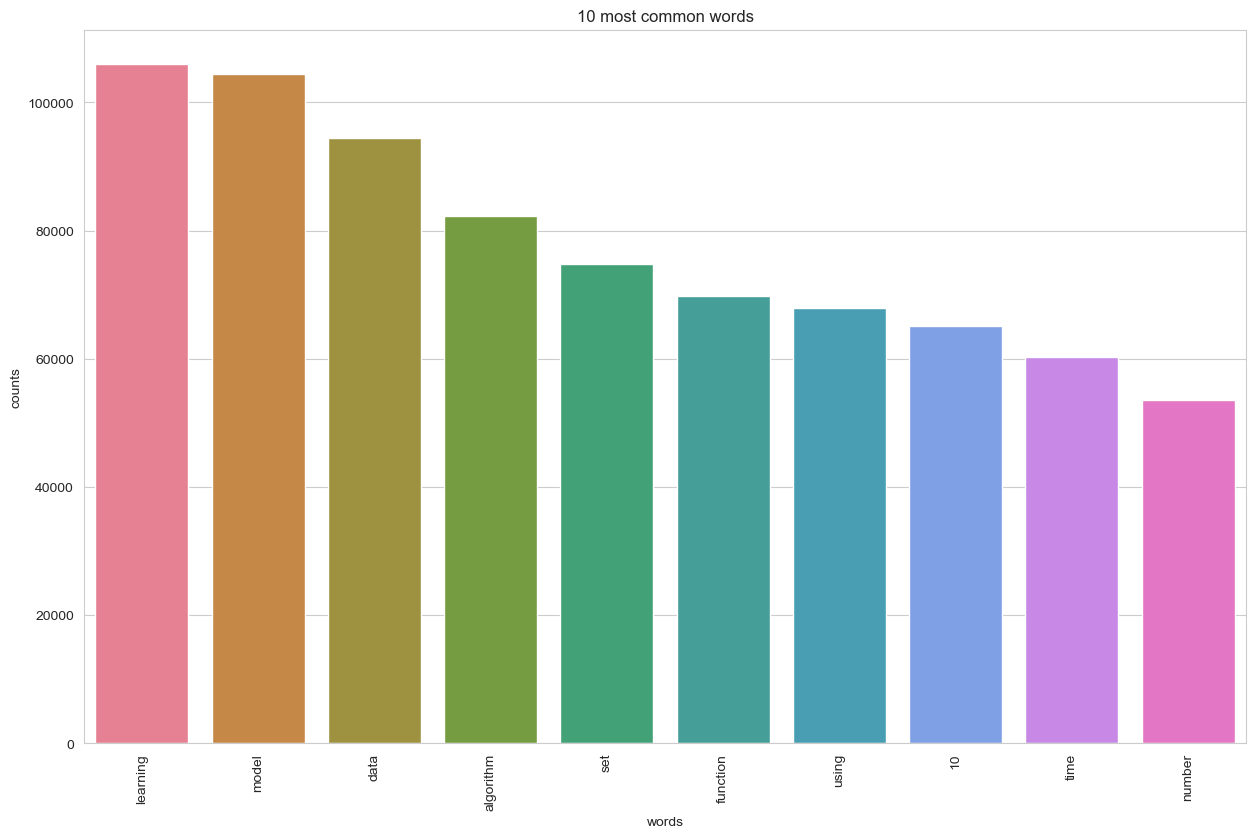

In [21]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=x_pos, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(papers['paper_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

### LDA model tranining

To keep things simple, we will only tweak the number of topic parameters: number_topics and number_words.

We apply the *fit* function to our count_data.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html


In [23]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
learning state policy time algorithm model function action regret using

Topic #1:
network model time neural input figure neurons learning networks function

Topic #2:
data algorithm set learning model function distribution 10 using number

Topic #3:
model image training data using images models learning set features

Topic #4:
algorithm matrix problem function theorem learning 10 convex data let


In [25]:
test_data=["my images are difficult to learn", "it takes a lot of time to train a model"]
transformed_test_data= count_vectorizer.transform(test_data)
print(transformed_test_data)

  (0, 120549)	1
  (0, 163063)	1
  (0, 183684)	1
  (1, 189182)	1
  (1, 201629)	1
  (1, 268021)	1
  (1, 272347)	1
  (1, 274903)	1


In [27]:
lda.transform(transformed_test_data)

array([[0.0508904 , 0.05038812, 0.05051122, 0.79796472, 0.05024554],
       [0.03447292, 0.54558867, 0.03408778, 0.35205326, 0.03379737]])

### Analyzing our LDA model

Now that we have a trained model let’s visualize the topics for interpretability. 
To do so, we’ll use a popular visualization package, *pyLDAvis* which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.
For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

You need to install *pyldavis* through the command line, following the instructions:

https://anaconda.org/conda-forge/pyldavis

WARNING: running the next cell takes a long time and you need some memory to run it. However, the result is spectacular.

In [32]:
import pyLDAvis
from pyLDAvis import lda_model as sklearn_lda
pyLDAvis.enable_notebook()
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.053008 -0.004342       1        1  30.795392
4      0.119436 -0.068006       2        1  20.270803
3     -0.071196  0.047023       3        1  19.024489
1     -0.132322 -0.066790       4        1  16.003177
0      0.031075  0.092116       5        1  13.906140, topic_info=           Term          Freq         Total Category  logprob  loglift
162992    image  29412.000000  29412.000000  Default  30.0000  30.0000
227697   policy  15330.000000  15330.000000  Default  29.0000  29.0000
163063   images  18964.000000  18964.000000  Default  28.0000  28.0000
207886  network  43823.000000  43823.000000  Default  27.0000  27.0000
194320   matrix  42482.000000  42482.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
11858        10   6743.552005  64195.966892   Topic5  -5.9104  -0.2805
253177      set   6745.378676  73670.906165   Topic5  -5.9101  -0.4179
231211  problem   6492.531516  51804.753922   Topic5  -5.9483  -0.1040
90749     based   6216.293905  42458.809870   Topic5  -5.9918   0.0515
207886  network   6082.751485  43823.869032   Topic5  -6.0135  -0.0019

[531 rows x 6 columns], token_table=        Topic      Freq   Term
term                          
11858       1  0.366799     10
11858       2  0.255250     10
11858       3  0.131768     10
11858       4  0.141115     10
11858       5  0.105053     10
...       ...       ...    ...
296494      5  0.462325     xt
297937      1  0.992799  yeast
297937      3  0.003940  yeast
298808      1  0.994790    ylx
298808      3  0.003540    ylx

[1404 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 2, 1])

## BERT topic modeling

Read the Maarten Grootendorst's work on topic modeling with BERT:

https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

https://towardsdatascience.com/interactive-topic-modeling-with-bertopic-1ea55e7d73d8

## End of this notebook